In [6]:
import gensim
import multiprocessing
import numpy as np
import pickle

archivoModelo = 'Vectores.w2v'
archivoComentarios = 'SoloTextos.txt'
sentences = gensim.models.word2vec.Text8Corpus(archivoComentarios)

In [21]:
#Dimensionality of the resulting word vectors
num_features = 300
#Minimum word count threshold
min_word_count = 2
#Number of threads to run in parallel
num_workers = multiprocessing.cpu_count()
#Context window length
context_size = 5
#Seed for the RNG, to make the result reproducible
seed = 1

modelo = gensim.models.FastText(
    sg=1,
    seed=seed,
    workers=num_workers, 
    size=num_features, 
    min_count=min_word_count, 
    window=context_size)

modelo.build_vocab(sentences=sentences)
print("Vocabulario construido")
print("Tamaño de vocabulario de Word2Vec: ", len(modelo.wv.vocab))
#Start training the model
print("Inicio entrenamiento")
modelo.train(sentences=sentences,total_examples=modelo.corpus_count, epochs=50)
print("Fin entrenamiento")
modelo.save(archivoModelo)

#Va a extraer el vocabulario y sus emebddings y exportarlos en dos archivos separados 
#para poder ser usados en tensorflow
vocab = modelo.wv.vocab
embeddings = np.array([modelo.wv.get_vector(k) for k in vocab.keys()])
with open('fasttext_vocabulario.dat', 'wb') as fw:
    pickle.dump(vocab, fw, protocol=pickle.HIGHEST_PROTOCOL)
np.save('fasttext_embeddings.npy', embeddings)

print("Modelo guardado")

Vocabulario construido
Tamaño de vocabulario de Word2Vec:  7162
Inicio entrenamiento
Fin entrenamiento
Modelo guardado


In [11]:
modelo = gensim.models.word2vec.Word2Vec.load(archivoModelo)  # Cargar el modelo ya entrenado
count = 10000
word_vectors_matrix = np.ndarray(shape=(count, num_features), dtype='float64')
word_list = []
i = 0
for word in modelo.wv.vocab:
    word_vectors_matrix[i] = modelo[word]
    word_list.append(word)
    i = i+1
    if i == count:
        break
print("word_vectors_matrix shape is ", word_vectors_matrix.shape)

word_vectors_matrix shape is  (10000, 300)


C:\Users\joax\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [4]:
import sklearn.manifold
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
word_vectors_matrix_2d = tsne.fit_transform(word_vectors_matrix)
print("word_vectors_matrix_2d shape is ", word_vectors_matrix_2d.shape)

KeyboardInterrupt: 

In [13]:
import pandas as pd
points = pd.DataFrame(
    [
        (word, coords[0], coords[1]) 
        for word, coords in [
            (word, word_vectors_matrix_2d[word_list.index(word)])
            for word in word_list
        ]
    ],
    columns=["word", "x", "y"]
)
print("Points DataFrame built")
points.head((10))

Points DataFrame built


,word,x,y
0,salgo,-11.904973,47.953884
1,#veotv,8.940233,0.902348
2,día,0.793468,-2.433253
3,más,-9.195290,0.615915
4,@pauladelasheras,2.801057,-1.265136
5,no,-25.690565,-13.344938
6,ayudar,27.104803,38.212700
7,menos,9.365454,34.546051
8,besos,11.483550,27.240587
9,gracias,22.849623,34.955708


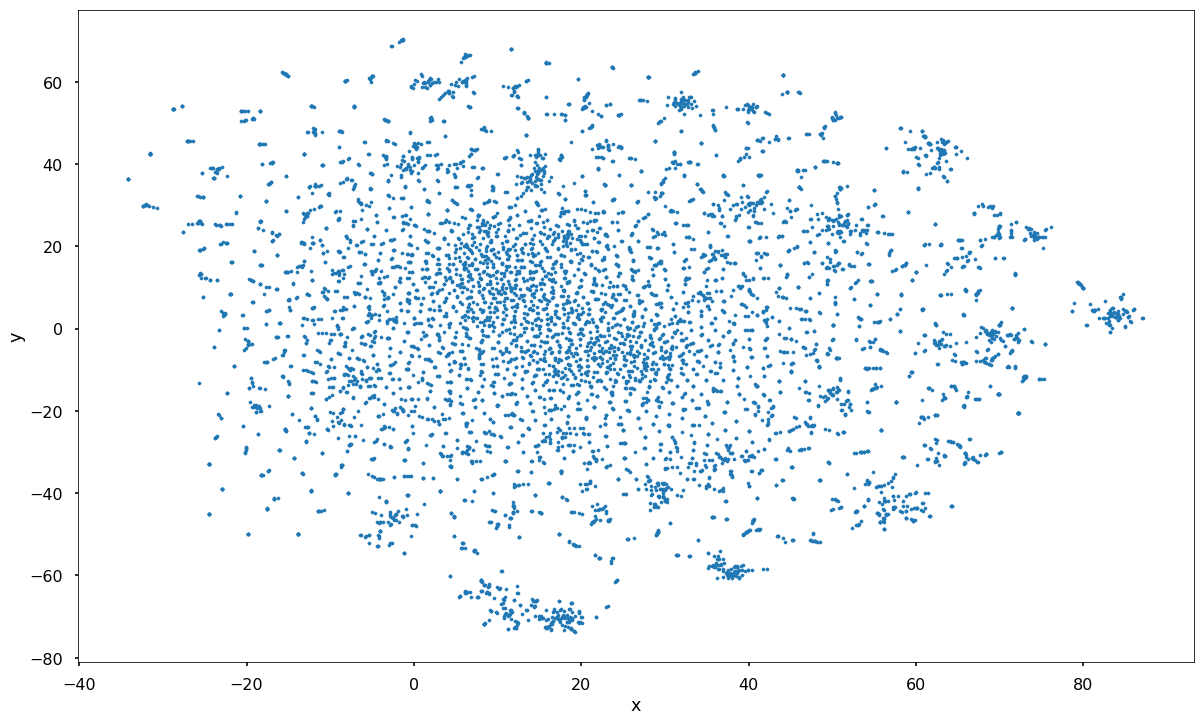

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context("poster")

points.plot.scatter("x", "y", s=10, figsize=(20, 12))

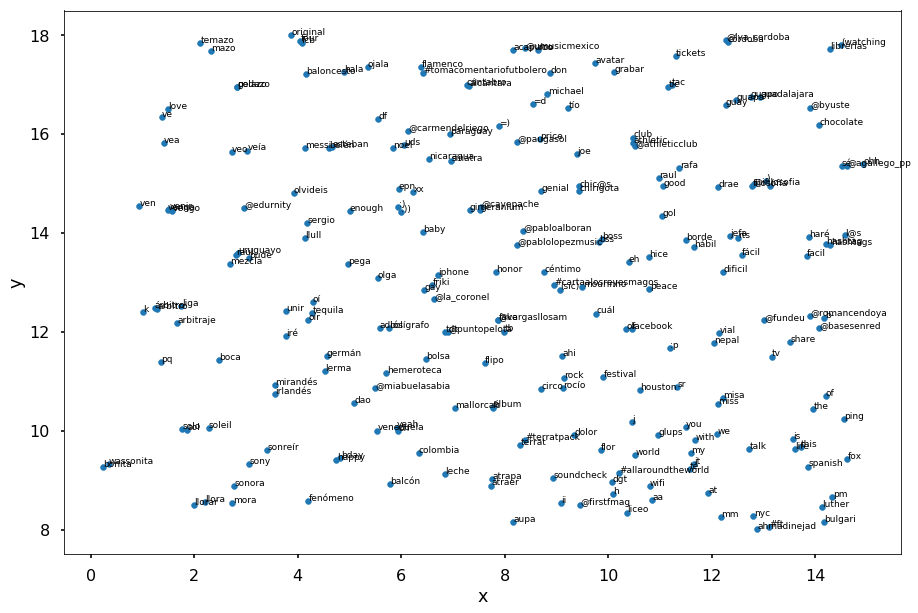

In [15]:
def plot_region (x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) &
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1]) 
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(15, 10))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=9)
    
plot_region(x_bounds=(0, 15), y_bounds=(8, 18))

In [22]:
modelo.wv.most_similar("feliz")

[('felices', 0.7334980964660645),
 ('felizxnumx', 0.7051045894622803),
 ('felipe', 0.6842105388641357),
 ('felicitaros', 0.6440603733062744),
 ('felicitar', 0.6356238126754761),
 ('felicidad', 0.6293153166770935),
 ('felipismo', 0.620718777179718),
 ('felicesfiestas', 0.6152381300926208),
 ('felicidades', 0.6064538955688477),
 ('felicitats', 0.6011013388633728)]